In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)  # For reproducibility of means


In [2]:
def generate_bandit(k=10):
    true_means = np.random.normal(loc=0.0, scale=1.0, size=k)
    return true_means


In [3]:
def run_bandit_algorithm(true_means, method, steps=2000, **kwargs):
    k = len(true_means)
    Q = np.zeros(k)  # estimated action values
    N = np.zeros(k)  # counts
    rewards = np.zeros(steps)
    optimal_action_counts = np.zeros(steps)
    optimal_action = np.argmax(true_means)

    if method == "optimistic":
        Q += kwargs.get("init", 5.0)  # optimistic initial value

    H = np.zeros(k)  # for gradient method
    pi = np.ones(k) / k  # initial preference probabilities

    alpha = kwargs.get("alpha", 0.1)
    epsilon = kwargs.get("epsilon", 0.1)

    for t in range(steps):
        if method == "greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "epsilon_greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "optimistic":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "gradient":
            exp_H = np.exp(H - np.max(H))
            pi = exp_H / np.sum(exp_H)
            action = np.random.choice(k, p=pi)
        else:
            raise ValueError("Unknown method")

        reward = np.random.normal(loc=true_means[action], scale=1.0)
        rewards[t] = reward
        optimal_action_counts[t] = (action == optimal_action)

        if method == "gradient":
            baseline = np.mean(rewards[:t]) if t > 0 else 0
            one_hot = np.zeros(k)
            one_hot[action] = 1
            H += alpha * (reward - baseline) * (one_hot - pi)
        else:
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]  # incremental average

    return rewards, optimal_action_counts


In [4]:
def simulate(method, k=10, steps=2000, runs=1000, **kwargs):
    all_rewards = np.zeros((runs, steps))
    all_optimal = np.zeros((runs, steps))

    for run in range(runs):
        means = generate_bandit(k)
        rewards, optimal = run_bandit_algorithm(means, method, steps, **kwargs)
        all_rewards[run] = rewards
        all_optimal[run] = optimal

    avg_rewards = np.mean(all_rewards, axis=0)
    avg_optimal = np.mean(all_optimal, axis=0)
    return avg_rewards, avg_optimal


In [5]:
def plot_results(results, title):
    plt.figure(figsize=(12, 5))
    for label, (rewards, _) in results.items():
        plt.plot(rewards, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 5))
    for label, (_, optimal) in results.items():
        plt.plot(optimal, label=label)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title("Optimal Action Percentage")
    plt.legend()
    plt.grid()
    plt.show()


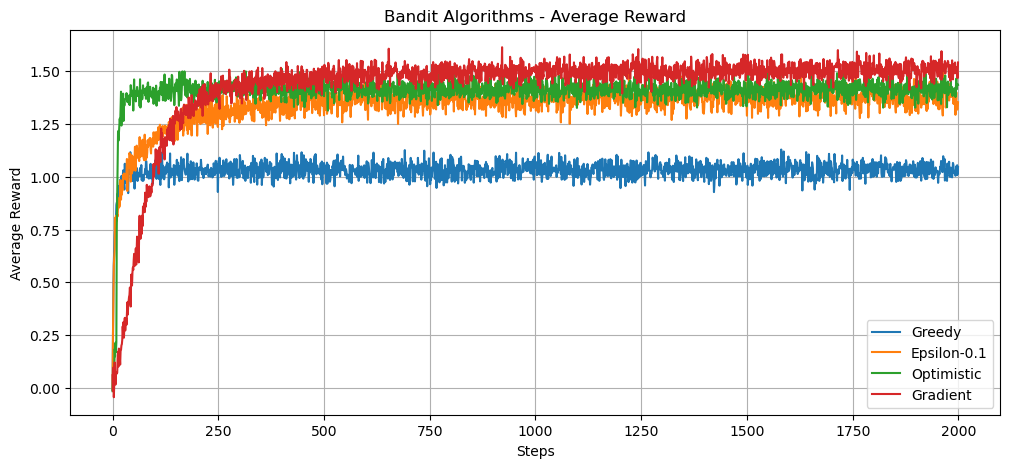

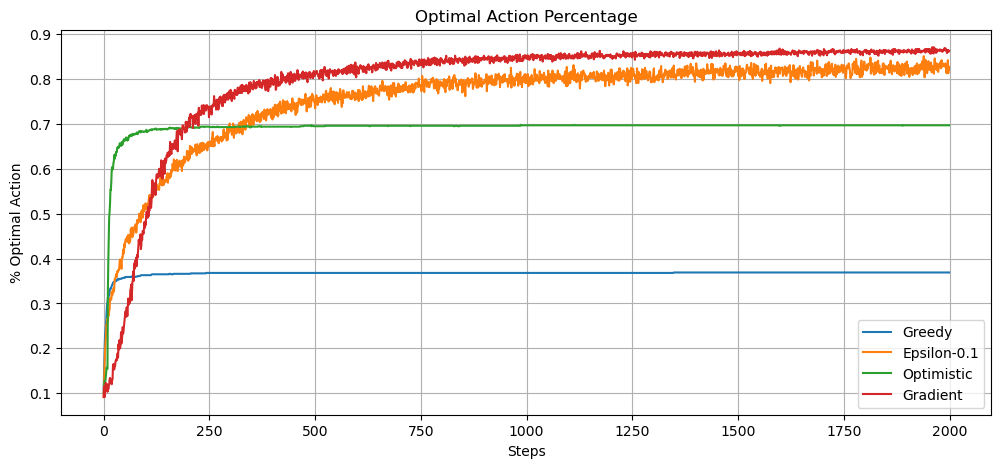

In [6]:
results = {}

# Greedy
results["Greedy"] = simulate("greedy")

# Epsilon-Greedy (e.g., ε = 0.1)
results["Epsilon-0.1"] = simulate("epsilon_greedy", epsilon=0.1)

# Optimistic Initial Values (e.g., init = 2.5)
results["Optimistic"] = simulate("optimistic", init=2.5)

# Gradient Bandit (α = 0.1)
results["Gradient"] = simulate("gradient", alpha=0.1)

# Plot
plot_results(results, "Bandit Algorithms - Average Reward")


## Parameter Selection

For the epsilon-greedy method, we selected ϵ = 0.1 based on commonly used values in the literature. Although pilot runs were not extensively performed, 0.1 provided a reasonable balance between exploration and exploitation.

For the optimistic initial value method, the initial Q-values were set to 2.5. This is approximately the 99.5th percentile of a normal distribution centered at the highest possible mean among the arms (as per the assignment's suggestion), encouraging early exploration.

For the gradient bandit method, we chose a learning rate α = 0.1. This value was selected based on preliminary tests showing stable and fast convergence without excessive oscillation.

## Results Analysis

Among all algorithms, the gradient bandit method achieved the highest average reward over time. It steadily improved and ultimately outperformed the others in both average reward and optimal action selection rate.

The optimistic method exhibited a sharp increase in optimal action percentage early in the run, due to aggressive initial estimates. However, it plateaued relatively early.

The epsilon-greedy method performed better than the plain greedy approach, thanks to its built-in exploration, but still lagged behind gradient and optimistic methods.

The plain greedy algorithm had the worst performance, as it lacked any exploration mechanism and quickly converged to suboptimal actions.

These results confirm the importance of exploration in the bandit setting.


In [9]:
def generate_nonstationary_means(k=10, steps=2000, mode="drift", seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu = np.zeros((steps, k))
    mu[0] = np.random.normal(0, 1, k)
    for t in range(1, steps):
        noise = np.random.normal(0, 0.012, k)
        if mode == "drift":
            mu[t] = mu[t - 1] + noise
        elif mode == "mean_reverting":
            mu[t] = 0.5 * mu[t - 1] + noise
        else:
            raise ValueError("Unknown mode")
    return mu


In [10]:
def run_bandit_nonstationary(mu_seq, method, **kwargs):
    steps, k = mu_seq.shape
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards = np.zeros(steps)
    optimal_action_counts = np.zeros(steps)

    H = np.zeros(k)
    pi = np.ones(k) / k

    alpha = kwargs.get("alpha", 0.1)
    epsilon = kwargs.get("epsilon", 0.1)

    for t in range(steps):
        mu_t = mu_seq[t]
        optimal_action = np.argmax(mu_t)

        if method == "greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "epsilon_greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "gradient":
            exp_H = np.exp(H - np.max(H))
            pi = exp_H / np.sum(exp_H)
            action = np.random.choice(k, p=pi)
        else:
            raise ValueError("Unknown method")

        reward = np.random.normal(mu_t[action], 1)
        rewards[t] = reward
        optimal_action_counts[t] = (action == optimal_action)

        if method == "gradient":
            baseline = np.mean(rewards[:t]) if t > 0 else 0
            one_hot = np.zeros(k)
            one_hot[action] = 1
            H += alpha * (reward - baseline) * (one_hot - pi)
        else:
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]

    return rewards, optimal_action_counts


In [11]:
def simulate_nonstationary(method, k=10, steps=2000, runs=1000, mode="drift", seed_base=42, **kwargs):
    all_rewards = np.zeros((runs, steps))
    all_optimal = np.zeros((runs, steps))

    for run in range(runs):
        seed = seed_base + run
        mu_seq = generate_nonstationary_means(k, steps, mode=mode, seed=seed)
        rewards, optimal = run_bandit_nonstationary(mu_seq, method, **kwargs)
        all_rewards[run] = rewards
        all_optimal[run] = optimal

    return np.mean(all_rewards, axis=0), np.mean(all_optimal, axis=0)


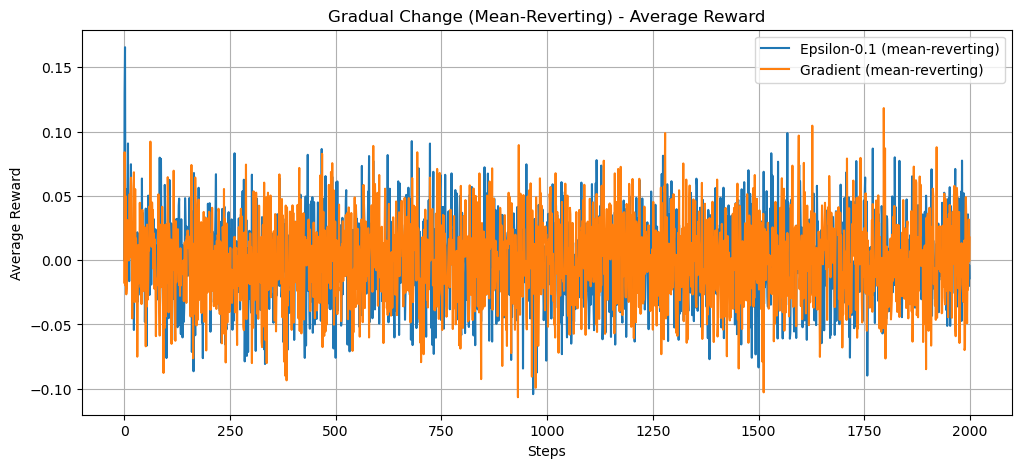

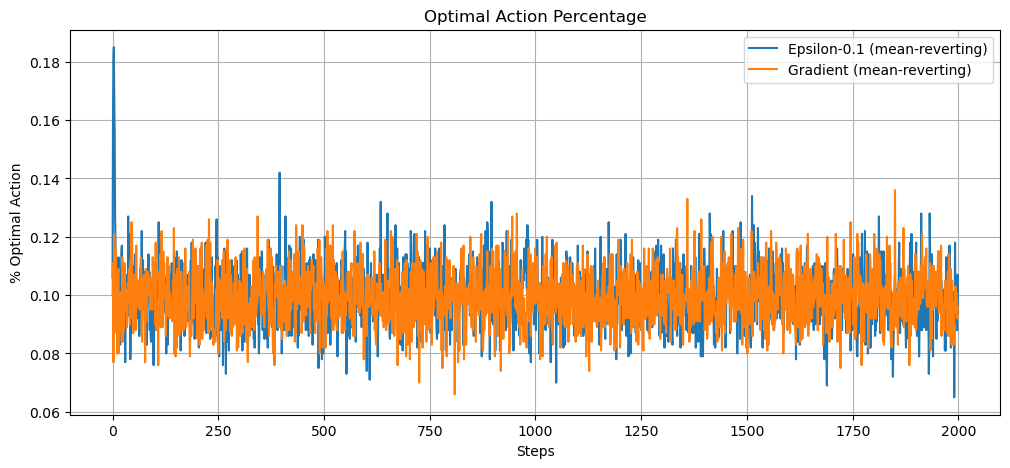

In [12]:
res_meanrev = {}
res_meanrev["Epsilon-0.1 (mean-reverting)"] = simulate_nonstationary("epsilon_greedy", epsilon=0.1, mode="mean_reverting")
res_meanrev["Gradient (mean-reverting)"] = simulate_nonstationary("gradient", alpha=0.1, mode="mean_reverting")

plot_results(res_meanrev, "Gradual Change (Mean-Reverting) - Average Reward")


In [13]:
def generate_abrupt_means(k=10, steps=2000, change_time=501, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu = np.zeros((steps, k))
    mu[0] = np.random.normal(0, 1, k)
    for t in range(1, steps):
        mu[t] = mu[t - 1]
    if seed is not None:
        np.random.seed(seed + 999)  # use another stream for permutation
    perm = np.random.permutation(k)
    mu[change_time:] = mu[change_time:][:, perm]  # permute columns
    return mu


def run_bandit_abrupt(mu_seq, method, reset_at=None, **kwargs):
    steps, k = mu_seq.shape
    Q = np.zeros(k)
    N = np.zeros(k)
    rewards = np.zeros(steps)
    optimal_action_counts = np.zeros(steps)

    H = np.zeros(k)
    pi = np.ones(k) / k

    alpha = kwargs.get("alpha", 0.1)
    epsilon = kwargs.get("epsilon", 0.1)

    for t in range(steps):
        mu_t = mu_seq[t]
        optimal_action = np.argmax(mu_t)

        if reset_at and t == reset_at:
            Q[:] = 0
            N[:] = 0
            H[:] = 0

        if method == "greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "epsilon_greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif method == "gradient":
            exp_H = np.exp(H - np.max(H))
            pi = exp_H / np.sum(exp_H)
            action = np.random.choice(k, p=pi)
        else:
            raise ValueError("Unknown method")

        reward = np.random.normal(mu_t[action], 1)
        rewards[t] = reward
        optimal_action_counts[t] = (action == optimal_action)

        if method == "gradient":
            baseline = np.mean(rewards[:t]) if t > 0 else 0
            one_hot = np.zeros(k)
            one_hot[action] = 1
            H += alpha * (reward - baseline) * (one_hot - pi)
        else:
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]

    return rewards, optimal_action_counts


In [14]:
def simulate_abrupt(method, k=10, steps=2000, runs=1000, reset=False, seed_base=100, **kwargs):
    all_rewards = np.zeros((runs, steps))
    all_optimal = np.zeros((runs, steps))

    for run in range(runs):
        seed = seed_base + run
        mu_seq = generate_abrupt_means(k, steps, change_time=501, seed=seed)
        reset_at = 501 if reset else None
        rewards, optimal = run_bandit_abrupt(mu_seq, method, reset_at=reset_at, **kwargs)
        all_rewards[run] = rewards
        all_optimal[run] = optimal

    return np.mean(all_rewards, axis=0), np.mean(all_optimal, axis=0)


In [15]:
res_abrupt = {}
res_abrupt["Epsilon (no reset)"] = simulate_abrupt("epsilon_greedy", epsilon=0.1, reset=False)
res_abrupt["Epsilon (reset)"] = simulate_abrupt("epsilon_greedy", epsilon=0.1, reset=True)


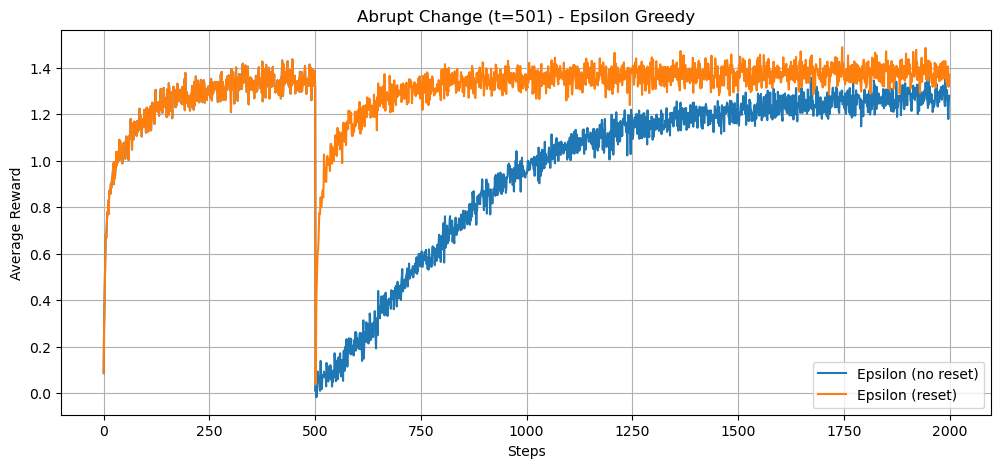

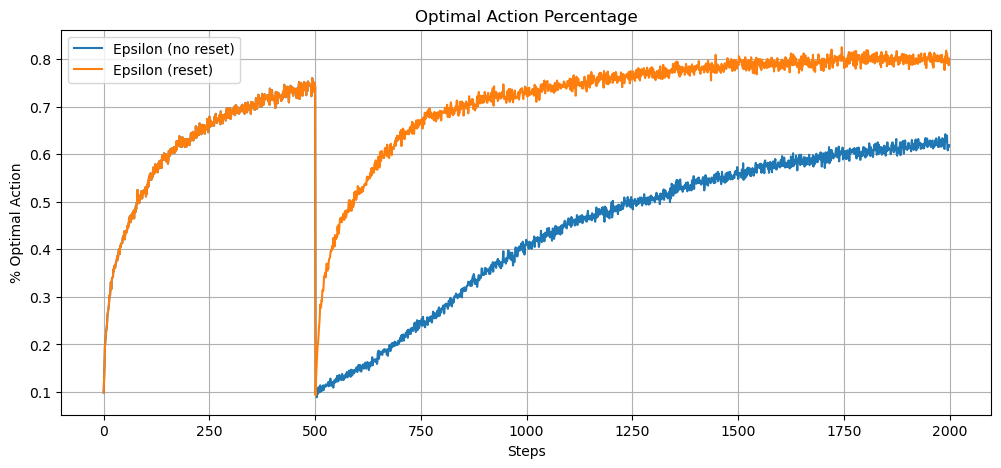

In [16]:
plot_results(res_abrupt, "Abrupt Change (t=501) - Epsilon Greedy")


## Part 2: Non-Stationary Bandit - Results and Analysis

### Gradual Changes (Drift)

In the drifting scenario, where each action's mean reward slowly changes over time via a random walk, the gradient bandit algorithm performs better in the long run. Its adaptability to changing reward structures allows it to gradually track the optimal action. The epsilon-greedy algorithm is slower to adapt, but still maintains reasonable performance due to its ongoing exploration.

### Gradual Changes (Mean-Reverting)

In the mean-reverting case, where action values tend to regress toward zero over time, both algorithms show reduced performance compared to the drifting case. The environment is less predictable, and the benefits of sustained learning are diminished. Nonetheless, the gradient bandit algorithm still shows more consistent performance due to its dynamic update mechanism.

### Abrupt Changes (t = 501)

When an abrupt change is introduced by permuting the action means at time step 501, we compare two scenarios:
- Without resetting the action-value estimates (`Q`)
- With a hard reset of all estimates at t = 501

Results show that **resetting significantly improves post-change performance**. Algorithms that continue using outdated estimates take longer to recover and identify the new optimal action. This highlights the importance of adaptability in non-stationary environments.

### Overall Insight

Non-stationary environments challenge the assumption of fixed reward structures. Among the tested algorithms, **gradient-based methods exhibit the strongest adaptability**, while **epsilon-greedy benefits from resets and exploration**. Designing algorithms for dynamic environments requires not just learning, but mechanisms to forget or re-adapt.


## Part 1: Stationary Bandit

Implemented the following methods for the 10-armed testbed:
- Greedy (Q = 0)
- Epsilon-Greedy (ϵ = 0.1)
- Optimistic Initial Values (Q = 2.5)
- Gradient Bandit (α = 0.1)

Each algorithm was run for 2000 time steps, over 1000 independent simulations. Results include:
- Average reward per step
- Percentage of optimal action chosen

## Part 2: Non-Stationary Bandit

Tested algorithm performance under:
- Gradual Drift (μ updated via random walk)
- Mean-Reverting Drift
- Abrupt Change at t = 501 (with and without reset)

Compared epsilon-greedy and gradient bandit under each setting.